In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from tsai.basics import *

v:\Git\Donguri\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
my_setup()

os              : Windows-10-10.0.19045-SP0
python          : 3.9.19
tsai            : 0.3.9
fastai          : 2.7.14
fastcore        : 1.5.32
torch           : 2.1.2+cu118
device          : 1 gpu (['NVIDIA GeForce GTX 1080 Ti'])
cpu cores       : 4
threads per cpu : 2
RAM             : 31.94 GB
GPU memory      : [11.0] GB


In [3]:
set_seed(137, False)

# Data

## Loading

In [4]:
# List of ticker symbols to process
tickers = ["BP", "CMCSA", "CSCO", "HSY", "IBM", "INTC", "MAA", "ORCL", "PG", "QCOM", "STZ", "UL", "VZ", "XOM"]
# Columns of interest from each CSV file
relevant_columns = ["Timestamp", "Close"]
# Directory where the CSV files are located
data_dir = "data/new/merged/"
# Initialize the global DataFrame to None
global_df = None
# Loop through each ticker symbol
for i, ticker in enumerate(tickers):
    # Read the CSV file for the current ticker
    df = pd.read_csv(f"{data_dir}{ticker}-merged-padded.csv")
    # Select only the relevant columns (Timestamp and Close)
    relevant_df = df[relevant_columns]
    # Rename the 'Close' column to include the ticker symbol
    renamed_columns = {col: f"{ticker}_{col}" for col in relevant_df.columns if col != "Timestamp"}
    relevant_df = relevant_df.rename(columns=renamed_columns)
    # If global_df is None, initialize it with relevant_df
    if global_df is None:
        global_df = relevant_df
    else:
        # Otherwise, merge the current relevant_df with global_df on the 'Timestamp' column
        global_df = global_df.merge(relevant_df, on="Timestamp", how="left")
# Move the 'Timestamp' column to the beginning of the DataFrame
global_df.insert(0, "Timestamp", global_df.pop("Timestamp"))
# Sort the DataFrame by 'Timestamp' in ascending order and reset the index
global_df = global_df.sort_values(by='Timestamp', ascending=True).reset_index(drop=True)

In [5]:
global_df.tail(5)

,Timestamp,BP_Close,CMCSA_Close,CSCO_Close,HSY_Close,IBM_Close,INTC_Close,MAA_Close,ORCL_Close,PG_Close,QCOM_Close,STZ_Close,UL_Close,VZ_Close,XOM_Close
17,2024-05-14,37.96,39.70,48.95,208.89,167.36,31.05,136.82,120.87,165.76,188.97,253.99,54.04,40.49,117.67
18,2024-05-15,37.76,39.25,49.67,205.41,168.26,31.27,137.71,121.63,166.51,194.61,252.29,54.48,40.49,118.58
19,2024-05-16,37.11,39.37,48.34,208.17,168.97,32.03,136.86,122.16,167.86,193.27,255.39,54.07,40.25,117.87
20,2024-05-17,37.49,39.27,48.17,207.04,169.03,31.83,137.74,123.50,167.64,193.86,255.43,54.75,40.06,119.64
21,2024-05-20,37.26,39.21,47.13,208.09,169.92,32.10,136.86,124.52,167.31,197.76,250.56,54.13,40.12,118.67


In [6]:
global_df.shape

(22, 15)

## Add more days (until 60)

### Load test data

In [7]:
test_df_path = "data/for_model/test_custom.csv"
test_df = pd.read_csv(test_df_path)
filtered_columns = [col for col in test_df.columns if "Close" in col or "Timestamp" in col]
test_df = test_df[filtered_columns][-(60-global_df.shape[0]):].reset_index(drop=True)

In [8]:
test_df.tail(5)

,Timestamp,BP_Close,CMCSA_Close,CSCO_Close,HSY_Close,IBM_Close,INTC_Close,MAA_Close,ORCL_Close,PG_Close,QCOM_Close,STZ_Close,UL_Close,VZ_Close,XOM_Close
33,2024-04-12,39.44,39.37,48.49,185.80,182.27,35.69,128.13,121.11,155.33,171.29,262.24,46.76,39.72,120.37
34,2024-04-15,39.07,39.43,48.24,182.57,181.25,36.31,126.63,119.88,155.45,169.84,258.52,46.71,40.11,119.68
35,2024-04-16,38.63,39.12,47.92,183.31,183.75,36.26,123.79,120.62,155.95,168.58,257.78,46.47,39.77,118.69
36,2024-04-17,38.37,38.99,47.79,182.45,183.10,35.68,124.80,118.67,156.96,164.32,257.31,46.69,39.78,118.63
37,2024-04-18,37.92,39.62,48.11,184.86,181.47,35.04,124.62,116.00,157.29,161.44,258.68,46.85,40.13,118.52


In [9]:
test_df.shape

(38, 15)

### Prepend test data to new data

In [10]:
demo_df = pd.concat([test_df, global_df], ignore_index=True)
demo_df = demo_df.drop(columns=["Timestamp"])

In [11]:
demo_df.tail(5)

,BP_Close,CMCSA_Close,CSCO_Close,HSY_Close,IBM_Close,INTC_Close,MAA_Close,ORCL_Close,PG_Close,QCOM_Close,STZ_Close,UL_Close,VZ_Close,XOM_Close
55,37.96,39.70,48.95,208.89,167.36,31.05,136.82,120.87,165.76,188.97,253.99,54.04,40.49,117.67
56,37.76,39.25,49.67,205.41,168.26,31.27,137.71,121.63,166.51,194.61,252.29,54.48,40.49,118.58
57,37.11,39.37,48.34,208.17,168.97,32.03,136.86,122.16,167.86,193.27,255.39,54.07,40.25,117.87
58,37.49,39.27,48.17,207.04,169.03,31.83,137.74,123.50,167.64,193.86,255.43,54.75,40.06,119.64
59,37.26,39.21,47.13,208.09,169.92,32.10,136.86,124.52,167.31,197.76,250.56,54.13,40.12,118.67


In [12]:
demo_df.shape

(60, 14)

## Scaling

In [13]:
scaler = load_object('data/for_model/scale_custom_14.pkl')
demo_df = scaler.transform(demo_df)
demo_df.tail(5)

,BP_Close,CMCSA_Close,CSCO_Close,HSY_Close,IBM_Close,INTC_Close,MAA_Close,ORCL_Close,PG_Close,QCOM_Close,STZ_Close,UL_Close,VZ_Close,XOM_Close
55,0.057706,-0.270772,1.106085,1.813504,0.495560,-0.459952,0.829268,4.005773,2.386775,3.221685,1.449040,0.800652,-1.060462,2.318900
56,0.030689,-0.307421,1.161895,1.745198,0.531752,-0.443016,0.850962,4.048039,2.412548,3.388045,1.427343,0.847756,-1.060462,2.375336
57,-0.057116,-0.297648,1.058802,1.799372,0.560303,-0.384507,0.830243,4.077515,2.458939,3.348520,1.466908,0.803864,-1.093640,2.331303
58,-0.005784,-0.305792,1.045625,1.777192,0.562716,-0.399904,0.851693,4.152037,2.451379,3.365922,1.467419,0.876661,-1.119907,2.441074
59,-0.036853,-0.310679,0.965010,1.797802,0.598506,-0.379118,0.830243,4.208763,2.440039,3.480958,1.405264,0.810287,-1.111612,2.380917


## Sliding window

In [14]:
# Convert the DataFrame to a NumPy array
X_np = demo_df.to_numpy()
# Convert the NumPy array to a PyTorch tensor
X_tensor = torch.tensor(X_np, dtype=torch.float32)
# Transpose the tensor to achieve the shape (14, 60)
X_tensor = X_tensor.T
# Add an additional dimension to the tensor to achieve the shape (1, 14, 60)
X_tensor = X_tensor.unsqueeze(0)
X_tensor.shape

torch.Size([1, 14, 60])

# Load model

In [15]:
best_n_layers=4
best_n_heads=6
best_d_model=24
best_d_ff=128
best_attn_dropout=0.0
best_dropout=0.4
best_stride=1
best_patch_len=15

learn = TSForecaster(X_tensor, torch.randn(1, 14, 5), splits=None,
    batch_size=None,
    arch="PatchTST",
    arch_config={
        'n_layers':best_n_layers,
        'n_heads':best_n_heads,
        'd_model':best_d_model,
        'd_ff':best_d_ff,
        'attn_dropout':best_attn_dropout,
        'dropout':best_dropout,
        'stride': best_stride,
        'patch_len': best_patch_len,
        'padding_patch': True,
    },
).model
learn.load_state_dict(torch.load(f'models/patchtst_custom_14_5.pth'))
learn.to(device)
learn.eval()

PatchTST(
  (model): _PatchTST_backbone(
    (revin_layer): RevIN()
    (padding_patch_layer): ReplicationPad1d((1, 0))
    (unfold): Unfold(kernel_size=(1, 15), dilation=1, padding=0, stride=1)
    (backbone): _TSTiEncoder(
      (W_P): Linear(in_features=15, out_features=24, bias=True)
      (dropout): Dropout(p=0.4, inplace=False)
      (layers): ModuleList(
        (0-3): 4 x _TSTiEncoderLayer(
          (self_attn): _MultiheadAttention(
            (W_Q): Linear(in_features=24, out_features=24, bias=True)
            (W_K): Linear(in_features=24, out_features=24, bias=True)
            (W_V): Linear(in_features=24, out_features=24, bias=True)
            (sdp_attn): _ScaledDotProductAttention(
              (attn_dropout): Dropout(p=0.0, inplace=False)
            )
            (to_out): Sequential(
              (0): Linear(in_features=24, out_features=24, bias=True)
              (1): Dropout(p=0.4, inplace=False)
            )
          )
          (dropout_attn): Dropout(p=0.4

# Inference

In [16]:
with torch.no_grad():
    y_pred = learn(X_tensor.to(device))
    y_pred = y_pred[0]

## Unscale back to original scaling

In [17]:
# Convert tensor to numpy array
y_pred_np = y_pred.cpu().numpy().T
# Convert numpy array to pandas df
y_pred_df_scaled = pd.DataFrame(y_pred_np, columns=demo_df.columns)
# Unscale df back to original values
y_pred_df = scaler.inverse_transform(y_pred_df_scaled)
# Define the Timestamp values
timestamps = ["2024-05-21", "2024-05-22", "2024-05-23", "2024-05-24", "2024-05-27"]
# Convert the Timestamp values to a datetime format
timestamps = pd.to_datetime(timestamps)
# Add the Timestamp column to the DataFrame at the beginning
y_pred_df.insert(0, "Timestamp", timestamps)
y_pred_df

,Timestamp,BP_Close,CMCSA_Close,CSCO_Close,HSY_Close,IBM_Close,INTC_Close,MAA_Close,ORCL_Close,PG_Close,QCOM_Close,STZ_Close,UL_Close,VZ_Close,XOM_Close
0,2024-05-21,37.284836,39.140113,47.448698,209.131860,169.068241,31.658523,137.716279,124.042173,167.601994,199.329422,251.036094,54.493871,40.083953,118.732183
1,2024-05-22,37.376281,39.162798,47.456564,208.585026,169.631603,32.025550,137.324280,124.202972,167.294210,199.063798,251.186585,54.349736,40.139668,118.932380
2,2024-05-23,37.475546,39.178568,47.449313,207.871125,170.073444,32.244158,137.111059,124.407602,166.883576,198.993816,251.705671,54.198571,40.175843,119.131585
3,2024-05-24,37.462384,39.247381,47.563919,207.843084,170.909785,32.743315,137.025088,124.731626,166.720537,198.453629,251.689494,54.091788,40.230429,119.025553
4,2024-05-27,37.427098,39.153993,47.452062,207.604479,170.815438,32.495784,136.568429,124.662990,166.470645,197.941992,251.462235,53.905785,40.265134,119.136825


# Check against real values

In [20]:
timestamps_plot = np.array(global_df.iloc[5:]["Timestamp"].values, dtype='datetime64')
timestamps_plot = np.concatenate((timestamps_plot.tolist(), np.array(["2024-05-21", "2024-05-22", "2024-05-23", "2024-05-24", "2024-05-27"], dtype='datetime64').tolist()))
timestamps_plot[:-5]

array([datetime.date(2024, 4, 26), datetime.date(2024, 4, 29),
       datetime.date(2024, 4, 30), datetime.date(2024, 5, 1),
       datetime.date(2024, 5, 2), datetime.date(2024, 5, 3),
       datetime.date(2024, 5, 6), datetime.date(2024, 5, 7),
       datetime.date(2024, 5, 8), datetime.date(2024, 5, 9),
       datetime.date(2024, 5, 10), datetime.date(2024, 5, 13),
       datetime.date(2024, 5, 14), datetime.date(2024, 5, 15),
       datetime.date(2024, 5, 16), datetime.date(2024, 5, 17),
       datetime.date(2024, 5, 20)], dtype=object)

In [24]:
timestamps_plot[-5:-1]

array([datetime.date(2024, 5, 21), datetime.date(2024, 5, 22),
       datetime.date(2024, 5, 23), datetime.date(2024, 5, 24)],
      dtype=object)

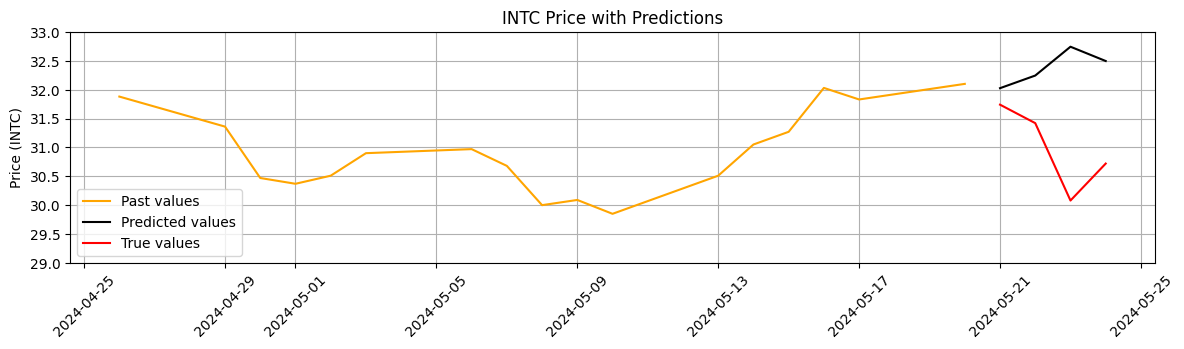

In [25]:
intc_real = [31.74, 31.42, 30.08, 30.72] # taken from google graph for intel stock

timestamps_plot = np.array(global_df.iloc[5:]["Timestamp"].values, dtype='datetime64')
timestamps_plot = np.concatenate((timestamps_plot.tolist(), np.array(["2024-05-21", "2024-05-22", "2024-05-23", "2024-05-24", "2024-05-27"], dtype='datetime64').tolist()))

plt.figure(figsize=(14, 3))
plt.plot(timestamps_plot[:-5], global_df.iloc[5:]["INTC_Close"], color="orange", label="Past values")
plt.plot(timestamps_plot[-5:-1], y_pred_df["INTC_Close"][-4:], color="black", label="Predicted values")
plt.plot(timestamps_plot[-5:-1], intc_real, color="red", label="True values")
plt.ylabel("Price (INTC)")
plt.title("INTC Price with Predictions")
plt.ylim(29, 33)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.grid(True)
plt.show()